In [6]:
from pygeoinf.interval.fem_solvers import NativeFEMSolver, FEMBasisFunction
from pygeoinf.interval.l2_space import L2Space
import numpy as np
import matplotlib.pyplot as plt

In [7]:
space = L2Space(10)

In [14]:
solver = NativeFEMSolver(interval=(0, 1), dof=100, boundary_conditions="dirichlet")
solver.setup()

In [15]:
basis_functions = solver._basis_provider.get_basis_functions()


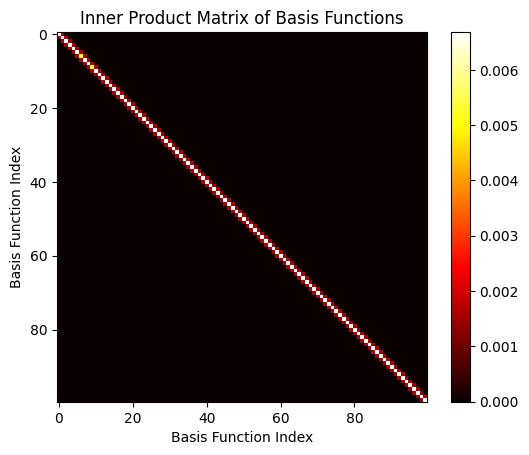

In [16]:
matrix = np.zeros((solver.dof, solver.dof))
for i in range(solver.dof):
    for j in range(i, solver.dof):
        matrix[i, j] = solver._basis_provider.space.inner_product(basis_functions[i], basis_functions[j])
        matrix[j, i] = matrix[i, j]
plt.imshow(matrix, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Inner Product Matrix of Basis Functions")
plt.xlabel("Basis Function Index")
plt.ylabel("Basis Function Index")
plt.show()